# Uncertainty Estimation with Probabilistic Discriminative Deep Networks

In this implementation exercise, we understand the notions of aleatoric and epistemic uncertainties and practice modelling such uncertainties for simple deep networks.

## Introduction
In standard discriminative modelling, we try to learn the parameters $\mathbf{\theta}$ of a deep network $f_{\mathbf{\theta}}:\mathcal{X}\rightarrow \mathcal{Y}$ that maps an input $x\in\mathcal{X}=\mathbb{R}^d$ to its corresponding output $\hat{y}=f_{\mathbf{\theta}}(\mathbf{x})\in\mathcal{Y}$. The parameters $\theta \in \mathbb{R}^p$ are trained on a training set of $n$ samples $\mathcal{D}=\{(\mathbf{x}_i, y_i)\}_{i=1}^{n}$

Predictive uncertainty estimation is concerned with reflecting a *degree of confidence* with a deep network's prediction. That is, instead of directly mapping the input $\mathbf{x}$ to the corresponding prediction $\hat{y}$, it maps it to a distribution over possible outputs $\hat{P}(y|\mathbf{x})$.

In this implementation practical, we first create a toy dataset and then try simple techniques to model two main types of uncertainties: *aleatoric* and *epistemic*.

## Types of Uncertainty
**Aleatoric uncertainty**, also known as irreducable uncertainty, refers to the inherent uncertainty that are present in the observations $(\mathbf{x},y)$. For instance, the measurements (*e.g.,* length of a tool) can be noisy depending on the precision of the measuring device (*e.g.*, a ruler with one-centimeter markings). This type of uncertainty cannot be remedied by better modelling or additional data, hence the adjective "irreducible". Aleatoric uncertainty can be either *homoscedastic* and *heteroscedastic*. Homoscedastic aleatoric uncertainty does not depend on a sample $\mathbf{x}$ (*e.g.*, the length of a tool can always have a fixed error of up to one centimeter) while a heteroscedastic aleatoric uncertainty can change depending on the sample (*e.g.*, a depth camera might give more error on certain surfaces than others depending on the material of the surface and reflectance and illuminance properties).  

**Epistemic uncertainty**, also known as knowledge uncertainty,  is induced by a model's lack of (enough) knowledge about a certain sample to make a confident prediction on it. As such, epistemic uncertainty is always heteroscedastic *i.e.*, sample-dependent. Knowledge uncertainty is sometimes further divided into separate *model* and *distributional* uncertainties reflecting the uncertainty induced by the inability of modeling and lack of enough data respectively. As such, epistemic uncertainty can be tackled by either improving the modelling or increasing the dataset size.

We will use a few simple methods, described in the lectures, to tackle these uncertainties by using

i) Maximum Likelihood Estimation (MLE) of aleatoric uncertainty, and

ii) Variational Inference (VI)-based Bayesian deep networks for epistemic uncertainty -- distributional uncertainty.

But let's first create a simple toy dataset.


In [48]:
#@title Import the necessary libraries for creating the data (numpy) and plotting it
import numpy as np
import matplotlib.pyplot as plt
import tqdm

%matplotlib inline

rand_seed = 123

np.random.seed(rand_seed)

# Toy Regression Dataset Creation

## Introduction
In this exercise the goal is to familiarize the students with basic concepts of deep probabilistic modelling. As such, we create and use a toy dataset since it will 1) allow us to put more emphasis on the pedagogical aspect of the practical, 2) it will make visualizing the important concepts easier, and 3) reduce the computational load necessary for the analysis.

## Underlying Function
For this toy dataset, we consider a one-dimensional regression task $\mathcal{X}=\mathbb{R}\rightarrow\mathcal{Y}=\mathbb{R}$. The underlying true function is the periodic even cosine function $y=\text{cos}(x)$. Modelling a periodic function can be generally challenging for a deep network.

## Basic Clean Training Set
For the basic clean training set $\mathcal{D}$, we create $n=100$ samples with $x\in[-1.3\pi,1.3\pi]$ and store them in the following variables.

```
# X_train       # training points input
# Y_train_true  # training points clean label
```



In [49]:
#@title define a function to sample from the true distribution
def sample_cosine(n_samples,
                  domain,
                  gaussian_noise_std=None,
                  heteroscedastic_noise_fun=None):
    assert gaussian_noise_std is None or heteroscedastic_noise_fun is None,\
        "Either gaussian_noise_std and heteroscedastic_noise_fun can be provided"
    # we assume that the samples are uniformly distributed
    x = np.linspace(domain[0],
                    domain[1],
                    n_samples).reshape(-1, 1)

    if gaussian_noise_std is None and heteroscedastic_noise_fun is None:
        y = np.cos(x)
    else:
        gaussian_noise = np.random.randn(n_samples, 1)
        if heteroscedastic_noise_fun is None:
            y = np.cos(x) + gaussian_noise * gaussian_noise_std
        else:
            y = np.cos(x)
            y = y + heteroscedastic_noise_fun(gaussian_noise,x,y)

    return x,y

In [50]:
n_train = 100
domain_train= np.pi * np.array([-1.3, 1.3])
X_train, Y_train_true = sample_cosine(n_train,
                                      domain_train)

let's visually inspect our clean training data

In [51]:
#@title Define a function for visualization
def visualize_samples(samples_list,ux,uy,domain_visualization,title, figsize=(15, 4)):
    fig = plt.figure(figsize=figsize)
    for x_samples,y_samples,kwargs in samples_list:
        plt.scatter(x_samples, y_samples,**kwargs)

    plt.plot(ux, uy, linewidth=3, label='Underlying Function')
    plt.xlim(domain_visualization)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.grid()

In [52]:
#@title Sample at a higher resolution for visualization of the true function
domain_visualization = np.pi * np.array([-3.2, 3.2])
visualization_resolution = 1000
ux, uy = sample_cosine(visualization_resolution,
                       domain_visualization)

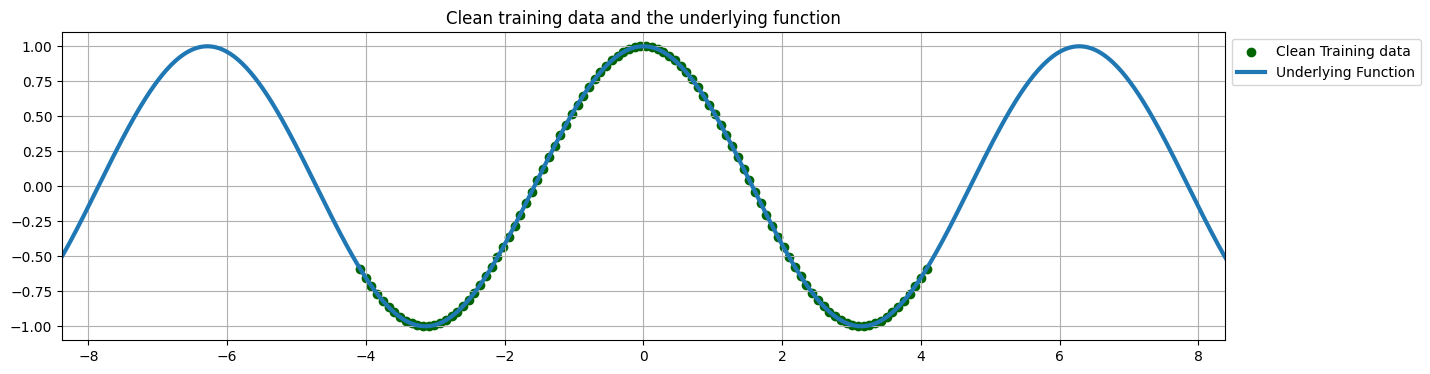

In [53]:
#@title Visualize training data
visualization_train_kwargs = {'marker':'o',
                              'linewidth':1,
                              'color':'darkgreen',
                              'label':'Clean Training data'}
visualize_samples_list = [(X_train,
                           Y_train_true,
                           visualization_train_kwargs)]
zooming_factor=1.2
visualize_samples(visualize_samples_list,
                  ux,
                  uy,
                  domain_visualization/zooming_factor,
                  title='Clean training data and the underlying function')

so, the training data densely covers the interval $-1.3\pi, 1.3\pi$.

## Basic Clean Test Set
Now let's create a test set that covers inputs beyond the observed interval during training. For the basic clean test set $\mathcal{D}_{test}$, we create $n_{test}=200$ samples with $x\in[-3\pi,3\pi]$ and store them in the following variables.

```
# X_test       # test points input
# Y_test_true  # test points clean label
```

In [54]:
n_test = 200
domain_test = np.pi * np.array([-3, 3])
X_test, Y_test_true = sample_cosine(n_test,
                                    domain_test)

let's visually inspect our clean test and training data

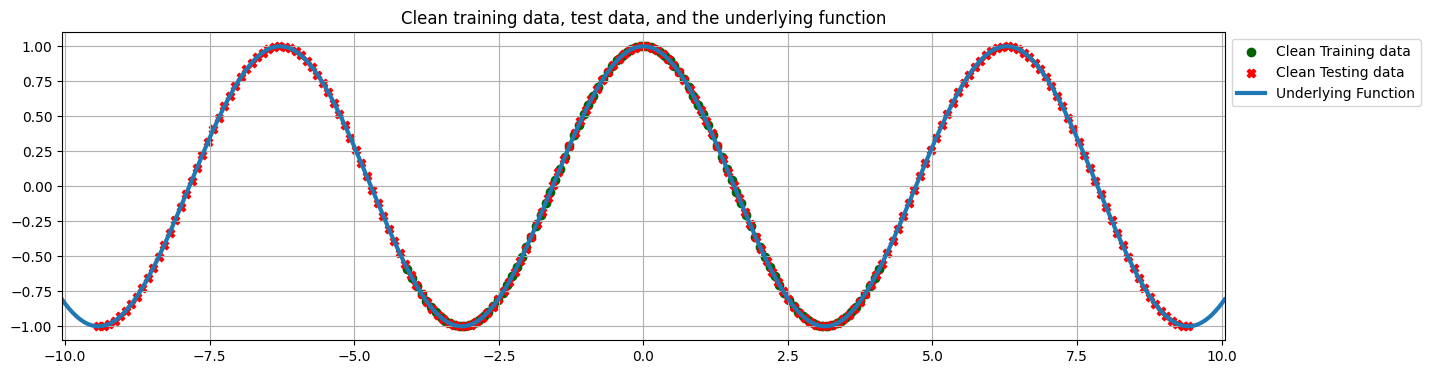

In [55]:
visualization_test_kwargs={'marker':'X',
                           'linewidth':1,
                           'color':'red',
                           'label':'Clean Testing data'}
# update visualization list
visualize_samples_list.append(
    (X_test,
     Y_test_true,
     visualization_test_kwargs))
visualize_samples(visualize_samples_list,
                  ux,
                  uy,
                  domain_visualization,
                  title='Clean training data, test data, and the underlying function')

## Homoscedastic Gaussian Noise on the Training Set
Datasets are commonly noisy and this noise can be due to various reasons, for instance because of the measurement errors. So, a more realistic dataset will contain some noise in the labels. We will first create a dataset containing *homoscedastic* label noise -- a noise independent of the sample. For this, we choose an additive Gaussian noise $\mathcal{N}(0,\sigma^2)$ with variance $\sigma^2=0.01$. We call the dataset with the homoscedastic noise $\mathcal{D}^{homo}$. It contains the same input samples as that of $\mathcal{D}$ but the corresponding labels $y$ are generated with additive gaussian noise and stored in the following variable.

```
# Y_train_homo  # training points label with homoscedastic additive Gaussiannoise
```

In [56]:
noise_std = 0.1
# sample again with noise
X_train, Y_train_hom = sample_cosine(n_train,
                                     domain_train,
                                     gaussian_noise_std=noise_std)

Now, let us visualize the training data with homoscedastic label noise this time.

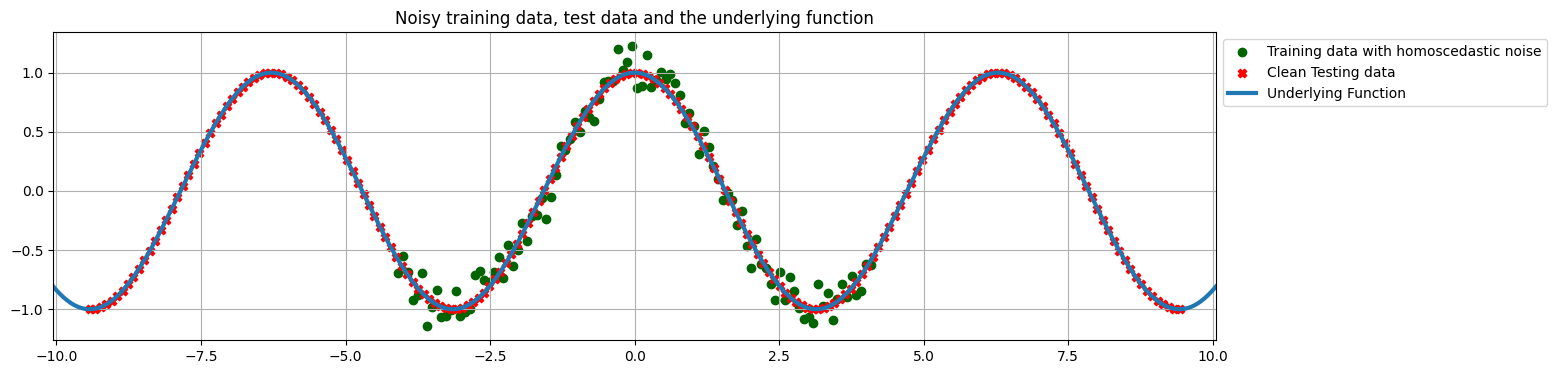

In [57]:
# update visualization information
visualization_train_kwargs['label']='Training data with homoscedastic noise'
visualize_samples_list[0]=(X_train,
                           Y_train_hom,
                           visualization_train_kwargs)
visualize_samples(visualize_samples_list,
                  ux,
                  uy,
                  domain_visualization,
                  title='Noisy training data, test data and the underlying function')

## Heteroscedastic Noise on the Training Set
We then create another dataset, but this time, containing *heteroscedastic* label noise -- a noise that is dependent on the sample. It is common for the label noise to be dependent on (specifically proportional to) the magnitude for continuous labels. For this reason, we choose a *multiplicative* Gaussian noise $\mathcal{N}(\mu,\sigma^2)$ with mean $\mu=1$ and variance $\sigma^2=0.04$. We call the dataset with the heteroscedastic noise $\mathcal{D}^{het}$. It contains the same input samples as that of $\mathcal{D}$ but the corresponding labels $y$ are generated with multiplicative gaussian noise and stored in the following variable.

```
# Y_train_het  # training points label with homoscedastic additive Gaussiannoise
```

In [58]:
noise_std = 0.2
noise_mean = 1
noise_fun = lambda noise,x,y: (noise_std * noise + noise_mean - 1) * y
X_train, Y_train_het = sample_cosine(n_train,
                                     domain_train,
                                     heteroscedastic_noise_fun=noise_fun)

Now, let us visualize the training data with heteroscedastic label noise this time.

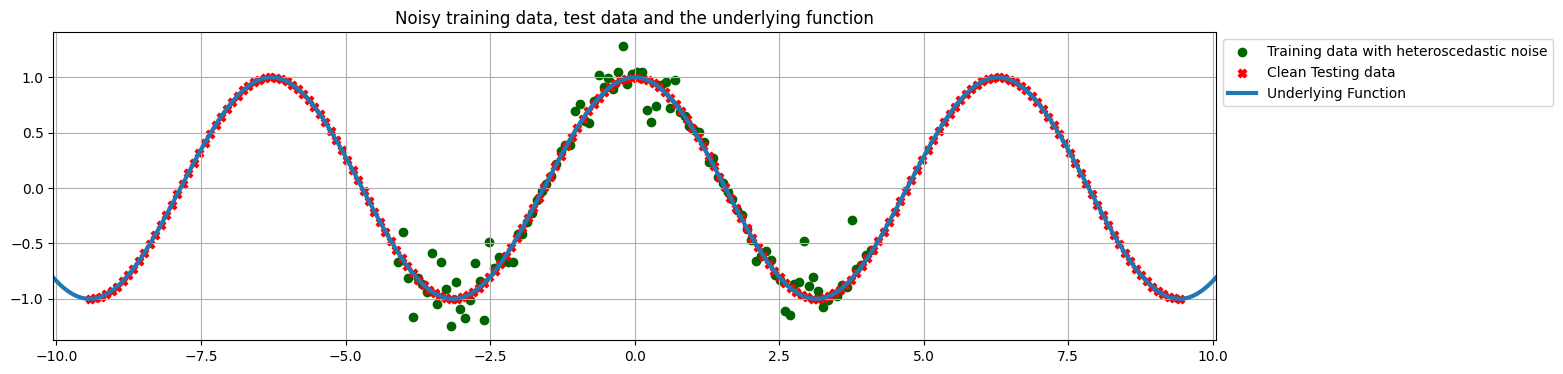

In [59]:
# update visualization information
visualization_train_kwargs['label']='Training data with heteroscedastic noise'
visualize_samples_list[0]=(X_train,
                           Y_train_het,
                           visualization_train_kwargs)
visualize_samples(visualize_samples_list,
                  ux,
                  uy,
                  domain_visualization,
                  title='Noisy training data, test data and the underlying function')

Note the higher noise when the underlying cosine value gets closer 1 or -1. Although, there might also be some optical illusion at play here due to the slope of the function!

# Regularized Risk Minimization

In a regularized risk minimization scheme, we train a model parametrized by $\mathbf{\theta}$, on a training set $\mathcal{D}=\{(x_i,y_i)\}_{i=1}^{n}$, using the following minimization:
\begin{align}
\mathbf{\theta}^*=\text{argmin}_{\mathbf{\theta}} \mathcal{L}(\mathcal{D}) + \Omega(\mathbf{\theta}) = \text{argmin}_{\mathbf{\theta}}\sum_{i=1}^{n}l(f_\theta(x_i), y_i) + \Omega(\mathbf{\theta}), \tag{1}
\end{align}

where $\mathcal{L}$ is the total loss function operating on the whole training set, $l$ is the sample loss function operating on individual training pairs $(x_i,y_i)$ and $\Omega$ is a regularization cost function.

Note that, it is quite common to use an *average loss* $
\frac{\sum_{i=1}^{n}}{n}$ instead of a sum, for it to be easier to set optimization parameters indepdencent of the training set / batch size.

## Training a Multi-Layer Perceptron (MLP)
Initially, we train a MLP, also known as fully-connected network, parametrized by its weights and biases $\mathbf{\theta}$. We use three hidden layers of size 100,40,100 units and the Rectified Linear Unit (ReLU), $\max(0,h)$, as the activation function. We adopt mean squared error as the loss function and weight decay as the regularization technique. Throughout this practical, we use Jax as the framework to implement our deep networks.

### Jax Deep Learning Framework
Jax uses a standard python (Numpy) implementation for describing a model's operations and enables GPU-optimized and differentible training using XLA and Autograd respectively. A simple tutorial can be found on the project page: https://github.com/google/jax.

Let us first import the necessary Jax libraries.

In [60]:
import time

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random
from jax import nn
from jax.example_libraries import optimizers

from functools import partial

# initialize the random generator
key = random.PRNGKey(rand_seed)

Next, we define the configuration of the fully-connected (FC) network:

In [61]:
# standard network's configurations
input_dim = X_train.shape[1]
output_dim = Y_train_true.shape[1]
layers_width = [100, 40, 100]
num_epochs = 1000
step_size = 1e-2

Now, we define two python functions; one for initializing the parameters of a FC *layer* and another for the feed-forward computation of a FC *layer*.

In [62]:
# Initialize the parameters of a standard fully-connected layer
def standard_fc_layer_init(input_dim, output_dim, key, scale=1e-2):
    keys = random.split(key, 2)
    weights = random.normal(keys[0], (output_dim, input_dim)) * scale
    biases  = random.normal(keys[1], (output_dim, 1)) * scale
    return weights, biases

In [63]:
# Forward pass of a standard fully-connected layer
def standard_fc_layer_forward(input, weights, biases):
    return jnp.dot(weights, input) + biases

Next, we define two python functions; one for initializing the parameters of a FC *network* and another for the feed-forward computation of a FC *network*.

In [64]:
# Initialize A standard fully-connected network
def standard_fc_network_init(input_dim, layers_width, output_dim, key):
    network_feature_dims = [input_dim, *layers_width, output_dim]
    number_of_layers = len(network_feature_dims[:-1])
    keys = random.split(key, number_of_layers)
    params = [standard_fc_layer_init(network_feature_dims[i],
                                    network_feature_dims[i+1],
                                    keys[i])
                for i in range(number_of_layers)]
    return params

In [65]:
# Forward pass of a standard fully-connected network
def standard_fc_network_forward(input, params, is_classification=False):
    representation = input
    for weights,biases in params[:-1]:
        representation = nn.relu(standard_fc_layer_forward(representation, weights, biases))
    representation = standard_fc_layer_forward(representation,params[-1][0], params[-1][1])

    if is_classification:
        logits = representation - nn.logsumexp(representation)
        return logits

    return representation

In the following, we define a python function corresponding to the mean squared error (MSE) loss, as

\begin{align}
\mathcal{L}(\mathcal{D})=\frac{1}{n}\sum_{i=1}^{n}l(f_\theta(x_i),y_i)=\frac{1}{n}\sum_{i=1}^{n}(f_\theta(x_i)-y_i)^2
\end{align}

In [66]:
def loss_mse(params, X, Y):
    """ Compute the MSE loss """
    preds = standard_fc_network_forward(X, params)
    return jnp.mean(jnp.power(preds[0,:] - Y, 2))

Finally, we implement the code necessary for optimizing the network's parameters using the training data.

In [67]:
# Compute the gradient for a batch and update the parameters
@partial(jit, static_argnums=(4,))
def update(params, X, Y, opt_state, loss):
    value, grads = value_and_grad(loss)(params, X, Y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [68]:
# Implements a learning loop over epochs.
def run_training_loop(num_epochs, opt_state, X, Y, X_test, Y_test, num_layers, loss):
    # Initialize placeholder for logging
    train_loss, train_mse, test_mse = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial loss after random init
    train_loss.append(loss(params, X.T, Y.T))
    train_mse.append(loss_mse(params[:num_layers], X.T, Y.T))
    test_mse.append(loss_mse(params[:num_layers], X_test.T, Y_test.T))
    print('Starting loss: ', train_loss[-1], ' Starting mse: ', train_mse[-1])

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss_val = update(params, X.T, Y.T, opt_state, loss)

        epoch_time = time.time() - start_time
        test_mse.append(loss_mse(params[:num_layers], X_test.T, Y_test.T))
        train_loss.append(loss(params, X.T, Y.T))
        train_mse.append(loss_mse(params[:num_layers], X.T, Y.T))
        if epoch==0 or (epoch+1)%200 == 0:
            print("Epoch {} | T: {:0.6f} | Train loss:"
                  " {:0.3f} | Train mse: {:0.3f} | Test mse:"
                  " {:0.3f}".format(epoch+1,
                                    epoch_time,
                                    train_loss[-1],
                                    train_mse[-1],
                                    test_mse[-1]))

    return params, train_loss, train_mse, test_mse

In [69]:
def visulize_predictions(Y_test_pred, title_text, X_train=[], Y_train=[], sigma_param=-1):
    fig = plt.figure(figsize=(15, 4))
    ux = np.pi * np.linspace(-3, 3, 1000).reshape(-1, 1)
    uy = np.cos(ux)
    plt.plot(ux, uy, linewidth=3, label='Underlying Function')
    plt.plot(X_test, Y_test_pred.T, linewidth=3, color='red', label='Prediction on Testing Points')
    axes = plt.gca()
    axes.set_ylim([-1.5,1.5])
    if not jnp.isscalar(sigma_param) or sigma_param >= 0:
        plt.fill_between(X_test.ravel(),
                        (Y_test_pred + 2 * sigma_param).ravel(),
                        (Y_test_pred - 2 * sigma_param).ravel(),
                        alpha=0.3, label='Uncertainty')
        plt.scatter(X_train,
                    Y_train,
                    marker='o',
                    linewidth=1,
                    color='darkgreen',
                    label='Clean Training data')
    plt.title(title_text)
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.grid()

What all in place, now, let us launch the training for the clean dataset and visualize the learnt function.

In [70]:
# Initialize the network parameters
params = standard_fc_network_init(input_dim,
                                  layers_width,
                                  output_dim,
                                  key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

params,\
train_loss,\
train_mse,\
test_mse = run_training_loop(num_epochs,
                             opt_state,
                             X_train,
                             Y_train_true,
                             X_test,
                             Y_test_true,
                             len(layers_width)+1,
                             loss_mse)

Starting loss:  0.554691  Starting mse:  0.554691
Epoch 1 | T: 0.806882 | Train loss: 0.547 | Train mse: 0.547 | Test mse: 0.503
Epoch 200 | T: 0.000603 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 0.898
Epoch 400 | T: 0.001270 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.462
Epoch 600 | T: 0.000510 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.624
Epoch 800 | T: 0.001172 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.789
Epoch 1000 | T: 0.001351 | Train loss: 0.000 | Train mse: 0.000 | Test mse: 1.840


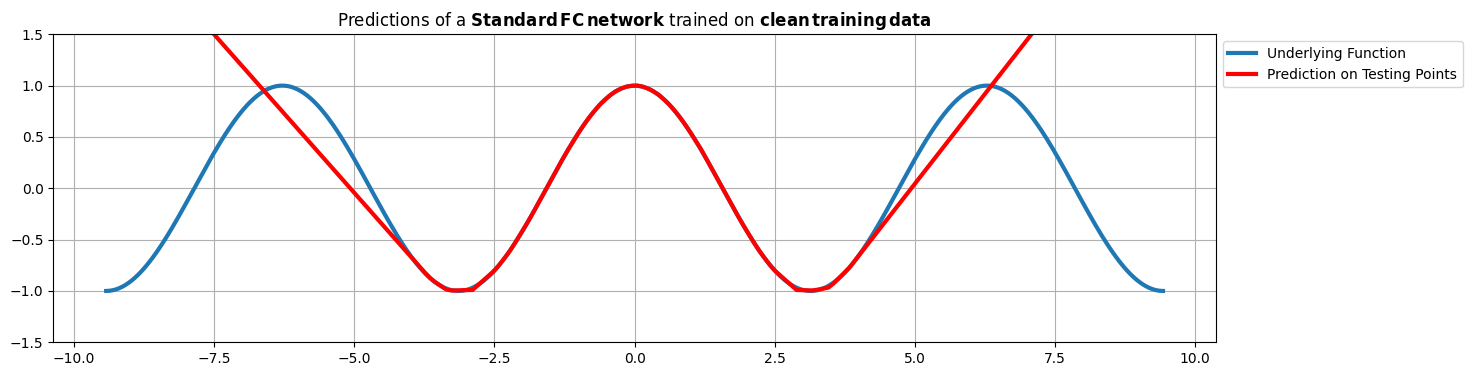

In [71]:
Y_test_pred = standard_fc_network_forward(X_test.T, params)
visulize_predictions(Y_test_pred,
                     r'Predictions of a $\bf{Standard\, FC\, network}$'
                     r' trained on $\bf{clean\, training\, data}$')

We get a great match in the training range $[-1.3\pi,1.3\pi]$ while the predictions become poor outside this range which is understandable due to the hardness of generalizing to periodic functions after only observing one period and in the absence of helpful inductive biases.

Now, let's train and test on the training data with homoscedastic noise

In [72]:
# Initialize the network parameters
params_hom = standard_fc_network_init(input_dim,
                                      layers_width,
                                      output_dim,
                                      key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_hom)

params_hom,\
train_loss_hom,\
train_mse_hom,\
test_mse_hom = run_training_loop(num_epochs,
                                 opt_state,
                                 X_train,
                                 Y_train_hom,
                                 X_test,
                                 Y_test_true,
                                 len(layers_width)+1,
                                 loss_mse)

Starting loss:  0.5805141  Starting mse:  0.5805141
Epoch 1 | T: 0.000429 | Train loss: 0.573 | Train mse: 0.573 | Test mse: 0.503
Epoch 200 | T: 0.000521 | Train loss: 0.011 | Train mse: 0.011 | Test mse: 0.669
Epoch 400 | T: 0.000614 | Train loss: 0.010 | Train mse: 0.010 | Test mse: 0.612
Epoch 600 | T: 0.000519 | Train loss: 0.010 | Train mse: 0.010 | Test mse: 0.693
Epoch 800 | T: 0.000487 | Train loss: 0.009 | Train mse: 0.009 | Test mse: 0.735
Epoch 1000 | T: 0.000503 | Train loss: 0.009 | Train mse: 0.009 | Test mse: 0.798


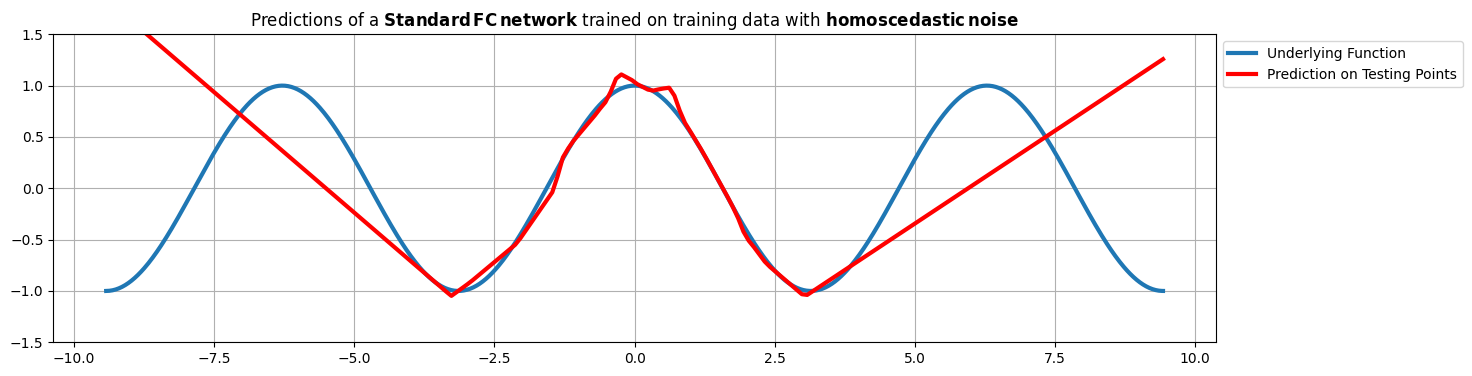

In [73]:
Y_test_pred_hom = standard_fc_network_forward(X_test.T, params_hom)
visulize_predictions(Y_test_pred_hom,
                     r'Predictions of a $\bf{Standard\, FC\, network}$'
                     r' trained on training data with $\bf{homoscedastic\, noise}$')

We can see that the network overfits to some of the noise present in the training data.

Let us go to the dataset exhibiting heteroscedastic label noise next:

In [74]:
# Initialize the network parameters
params_het = standard_fc_network_init(input_dim,
                                      layers_width,
                                      output_dim,
                                      key)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_het)

params_het,\
train_loss_het,\
train_mse_het,\
test_mse_het = run_training_loop(num_epochs,
                                 opt_state,
                                 X_train,
                                 Y_train_het,
                                 X_test,
                                 Y_test_true,
                                 len(layers_width)+1,
                                 loss_mse)

Starting loss:  0.56269145  Starting mse:  0.56269145
Epoch 1 | T: 0.001090 | Train loss: 0.556 | Train mse: 0.556 | Test mse: 0.503
Epoch 200 | T: 0.000578 | Train loss: 0.020 | Train mse: 0.020 | Test mse: 0.521
Epoch 400 | T: 0.001252 | Train loss: 0.020 | Train mse: 0.020 | Test mse: 0.567
Epoch 600 | T: 0.000585 | Train loss: 0.019 | Train mse: 0.019 | Test mse: 0.651
Epoch 800 | T: 0.000536 | Train loss: 0.019 | Train mse: 0.019 | Test mse: 0.769
Epoch 1000 | T: 0.000558 | Train loss: 0.019 | Train mse: 0.019 | Test mse: 0.832


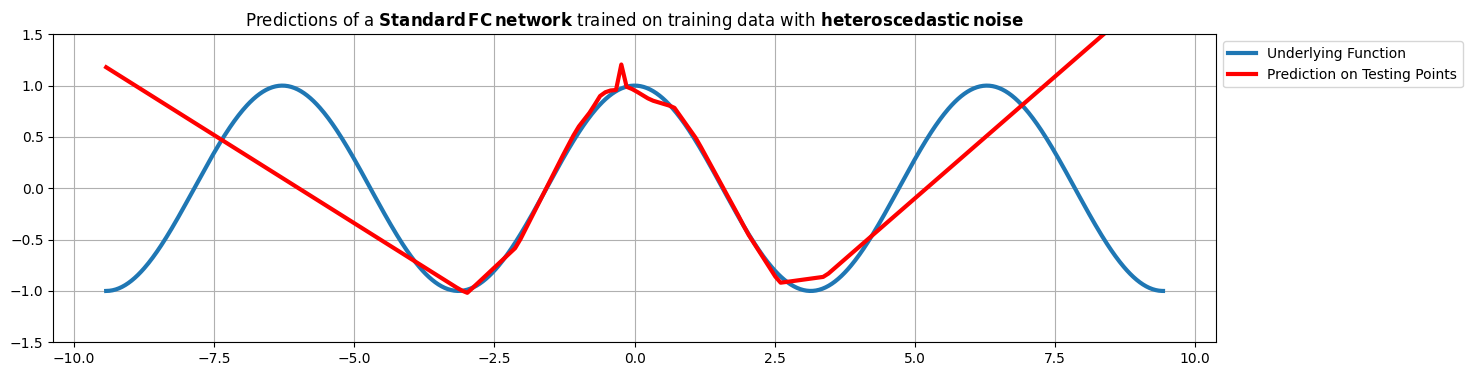

In [75]:
Y_test_pred_het = standard_fc_network_forward(X_test.T,
                                              params_het)
visulize_predictions(Y_test_pred_het,
                     r'Predictions of a $\bf{Standard\, FC\, network}$'
                     r' trained on training data with $\bf{heteroscedastic\, noise}$')

Here we (usually) see that the network overfits a bit more to the heteroscedastic noise present in the training data. We said "usually" since it depends on the randomly generated data and trained fit.

# Training with Assuming a Label Noise Distribution

In the lectures, we discussed that one way to model aleatoric uncertainty is using maximum likelihood estimation (MLE) in tandem with a model that can output probability distributions. Here, we are going to follow this idea to see how well this approach can predict the aleatoric uncertainty.

## Modelling Aleatoric Uncertainty: Learning to predict a fixed (homoscedastic) uncertainty
For a maximum likelihood estimation we need to devise a likelihood function. Let's assume a Gaussian likelihood function, parametrized by a deep network to give its mean and variance, given an input. In this first part, we assume the deep network produces a fixed variance independent of the input sample while the mean is dependent on the input sample. That is, our likelihood function has the following form:

\begin{align}
P(y|\mathbf{x};\mathbf{\theta}) = \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}),\sigma^2=f'_\theta).
\end{align}

Think(!) how this is the same as assuming an additive Gaussian noise with a fixed variance on the labels.

First, we consider an additional parameter for the fixed variance and initialize the rest of the network parameters as before.

In [76]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_clean_data = standard_fc_network_init(input_dim,
                                                        layers_width,
                                                        output_dim,
                                                        key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_clean_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_clean_data)

Then, we would like to find $\theta$ that maximizes the likelihood of our observed data:

\begin{align}
\mathbf{\theta}^*=\text{argmax}_\mathbf{\theta}\prod_{i=1}^{n}P(y_i|\mathbf{x}_i;\mathbf{\theta}).
\end{align}

Taking the log and plugging in the Normal distributions we get:

\begin{align}
\mathbf{\theta}^*=\text{argmax}_\mathbf{\theta}\sum_{i=1}^{n}\log \mathcal{N}(\mu=f_{\mathbf{\theta}}(\mathbf{x}_i),\sigma^2=f'_\theta)|_{y_i}= \text{argmin}_\mathbf{\theta}[...]
\end{align}

**========================**
####**TODO**: Complete Equations.

\begin{align}
\mathbf{\theta}^*= \text{argmin}_\mathbf{\theta}[\sum_{i=1}^{n}(- \log (\frac{1}{\sqrt{2π f'_\theta}}-\exp{\frac{(y_i-f_\theta(x_i))^2}{2 f'_\theta}}))]
= \text{argmin}_\mathbf{\theta}[\sum_{i=1}^{n}( \frac{1}{2}\log2π f'_\theta+\frac{(y_i-f_\theta(x_i))^2}{2 f'_\theta})]
\end{align}
**========================**



Your job is now to fill in the missing part above and implement the corresponding loss function. Note that the expected term is an *argmin*.

**Important note.** While the log product of the MLE leads to a sum term of the samples' negative log likelihoods, in practice, similar to the RRM case, we often times turn the sum into a mean, especially when used with mini-batch training, since that makes a universal setting of a learning rate and generally the hyperparameters simpler. We expect you to do the same and turn the sum into a mean in your code below, as otherwise, you will have to search for proper hyperparameters, particularly the learning rate.

In [77]:
def loss_mle_homoscedastic(params, X, Y):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    1. Assume params[-1] contains the natural logarithm of the standard_deviation
    2. Return the total loss calculated as you derived above.
    """
    preds = standard_fc_network_forward(X, params[:-1])
    var = jnp.exp(params[-1])**2
    loss = jnp.mean(0.5*(jnp.log(2 * jnp.pi*var)) + ((Y - preds)**2) / (2*var))
    return loss

Starting loss:  6.2431397  Starting mse:  0.554691
Epoch 1 | T: 0.959048 | Train loss: 6.023 | Train mse: 0.547 | Test mse: 0.503
Epoch 200 | T: 0.000548 | Train loss: -0.746 | Train mse: 0.000 | Test mse: 0.639
Epoch 400 | T: 0.000521 | Train loss: -1.396 | Train mse: 0.000 | Test mse: 1.015
Epoch 600 | T: 0.002105 | Train loss: -1.988 | Train mse: 0.000 | Test mse: 1.235
Epoch 800 | T: 0.000763 | Train loss: -2.514 | Train mse: 0.000 | Test mse: 1.304
Epoch 1000 | T: 0.000547 | Train loss: -2.553 | Train mse: 0.000 | Test mse: 1.270
The final trained homoscedastic standard deviation for clean data is:  0.0203953


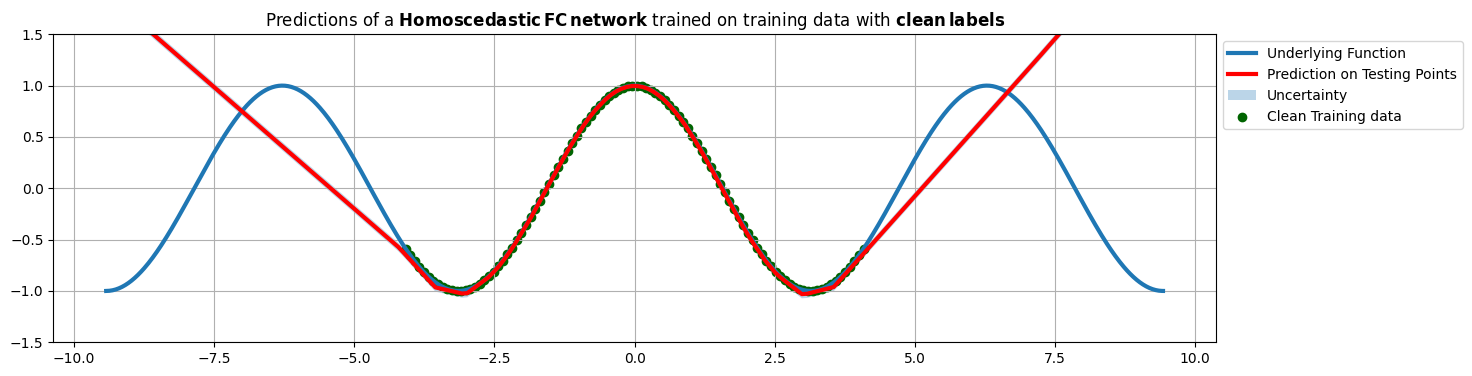

In [78]:
params_homo_model_clean_data,\
train_loss_homo_model_clean_data,\
train_mse_homo_model_clean_data,\
test_mse_homo_model_clean_data = run_training_loop(num_epochs,
                                                   opt_state, X_train,
                                                   Y_train_true, X_test,
                                                   Y_test_true,
                                                   len(layers_width)+1,
                                                   loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_clean_data[-1])
print('The final trained homoscedastic standard deviation'
      ' for clean data is: ',
      sigma_param)

Y_test_pred_homo_model_clean_data = standard_fc_network_forward(X_test.T,
                                                                params_homo_model_clean_data[:-1])

visulize_predictions(Y_test_pred_homo_model_clean_data,
                     r'Predictions of a $\bf{Homoscedastic\, FC\, network}$'
                     r' trained on training data with $\bf{clean\, labels}$',
                     X_train,
                     Y_train_true,
                     sigma_param)

The model with homoscedastic noise should learn a function that has negligible uncertainty.

Now, let us try it on the noisy data with fixed (homoscedastic) additive noise.

Starting loss:  6.5659275  Starting mse:  0.5805141
Epoch 1 | T: 0.000619 | Train loss: 6.341 | Train mse: 0.573 | Test mse: 0.503
Epoch 200 | T: 0.000612 | Train loss: -0.531 | Train mse: 0.011 | Test mse: 0.595
Epoch 400 | T: 0.000562 | Train loss: -0.815 | Train mse: 0.010 | Test mse: 0.664
Epoch 600 | T: 0.000687 | Train loss: -0.913 | Train mse: 0.009 | Test mse: 0.699
Epoch 800 | T: 0.000577 | Train loss: -0.941 | Train mse: 0.009 | Test mse: 0.814
Epoch 1000 | T: 0.000654 | Train loss: -0.951 | Train mse: 0.009 | Test mse: 0.870
The final trained homoscedastic standard deviation for data with fixed additive Gaussian noise is:  0.094463624


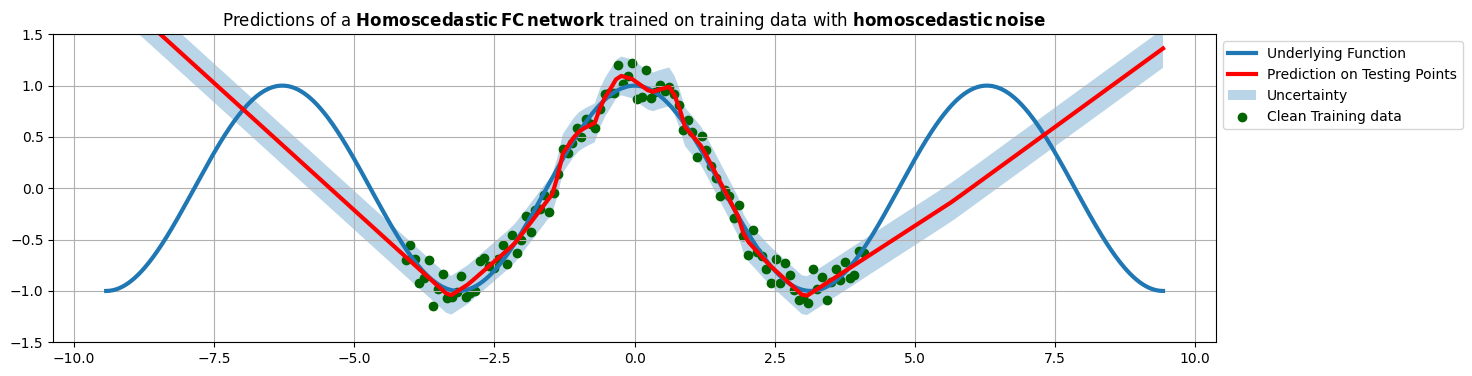

In [79]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_homo_data = standard_fc_network_init(input_dim,
                                                       layers_width,
                                                       output_dim,
                                                       key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_homo_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_homo_data)

params_homo_model_homo_data,\
train_loss_homo_model_homo_data,\
train_mse_homo_model_homo_data,\
test_mse_homo_model_homo_data = run_training_loop(num_epochs,
                                                  opt_state,
                                                  X_train,
                                                  Y_train_hom,
                                                  X_test,
                                                  Y_test_true,
                                                  len(layers_width)+1,
                                                  loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_homo_data[-1])
print('The final trained homoscedastic standard deviation '
      'for data with fixed additive Gaussian noise is: ',
      sigma_param)

Y_test_pred_homo_model_homo_data = standard_fc_network_forward(X_test.T,
                                                               params_homo_model_homo_data[:-1])

visulize_predictions(Y_test_pred_homo_model_homo_data,
                     r'Predictions of a $\bf{Homoscedastic\, FC\, network}$'
                     r' trained on training data with $\bf{homoscedastic\, noise}$',
                     X_train,
                     Y_train_hom,
                     sigma_param)


Are you happy with the predicted uncertainty? Does the uncertainty shading contain most observed datapoints?

Now, let us try it on the data with variable (heteroscedastic) label noise.

Starting loss:  6.3431444  Starting mse:  0.56269145
Epoch 1 | T: 0.001207 | Train loss: 6.128 | Train mse: 0.556 | Test mse: 0.503
Epoch 200 | T: 0.000605 | Train loss: -0.400 | Train mse: 0.019 | Test mse: 0.508
Epoch 400 | T: 0.000606 | Train loss: -0.569 | Train mse: 0.018 | Test mse: 0.548
Epoch 600 | T: 0.000596 | Train loss: -0.622 | Train mse: 0.017 | Test mse: 0.618
Epoch 800 | T: 0.000548 | Train loss: -0.636 | Train mse: 0.016 | Test mse: 0.710
Epoch 1000 | T: 0.000568 | Train loss: -0.644 | Train mse: 0.016 | Test mse: 0.821
The final trained homoscedastic standard deviation for data with variable (heteroscedastic) noise is:  0.1278778


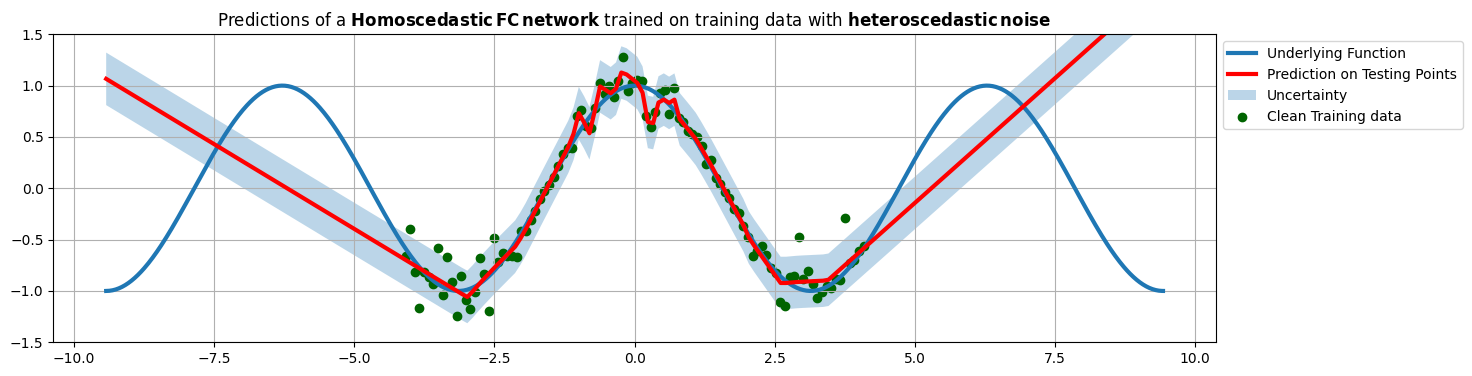

In [80]:
# assume one scalar for the fixed standard dev of the likelihood's Gaussian
sigma_param = jnp.array(jnp.log(0.2))

# Initialize the network parameters that will produce the mean of the likelihood's Gaussian
params_homo_model_het_data = standard_fc_network_init(input_dim,
                                                      layers_width,
                                                      output_dim,
                                                      key)

# add the likelihood's Gaussian's standard dev to the list of parameters
params_homo_model_het_data.append(sigma_param)

# Defining an optimizer in Jax
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params_homo_model_het_data)

params_homo_model_het_data,\
train_loss_homo_model_het_data,\
train_mse_homo_model_het_data,\
test_mse_homo_model_het_data = run_training_loop(num_epochs,
                                                 opt_state,
                                                 X_train,
                                                 Y_train_het,
                                                 X_test,
                                                 Y_test_true,
                                                 len(layers_width)+1,
                                                 loss_mle_homoscedastic)

sigma_param = jnp.exp(params_homo_model_het_data[-1])
print('The final trained homoscedastic standard deviation '
      'for data with variable (heteroscedastic) noise is: ',
      sigma_param)

Y_test_pred_homo_model_het_data = standard_fc_network_forward(X_test.T, params_homo_model_het_data[:-1])

visulize_predictions(Y_test_pred_homo_model_het_data,
                     r'Predictions of a $\bf{Homoscedastic\, FC\, network}$'
                     r' trained on training data with $\bf{heteroscedastic\, noise}$',
                     X_train,
                     Y_train_het,
                     sigma_param)


How about now? Are you as happy with the predicted uncertainty? Does the uncertainty shading contain similar amount of observed datapoints? Does the fixed uncertainty make sense in all regions of the input? If not as happy, we will re-explore this idea with heteroscedastic noise modeling in another implementation practical, so stay tuned!


---
---
---


# Variational Inference for Deep Regression Networks
In this part of the practical we are interested in epistemic uncertainty estimation with deep networks based on the following paper.

[1] Blundell et al., "Weight Uncertainty in Neural Networks", ICML 2015

---



In order to model epistemic uncertainty, we can use Bayesian modelling to obtain a posterior distribution on model parameters:

\begin{align}
P(\mathbf{\theta}|\mathcal{D})= \frac{P(\mathcal{D}|\mathbf{\theta})P(\mathbf{\theta})}{P(\mathcal{D})}
\end{align}



Using this posterior distribution, we can transfer the uncertainty in model parameters to uncertainty in predictive distribution, where, for a new test sample $\mathbf{x}$:

\begin{align}
  P(y|\mathbf{x},\mathcal{D})=\int P(y|\mathbf{x},\mathbf{\theta})P(\mathbf{\theta}|\mathcal{D})d\theta.
\end{align}

However, obtaining $P(\mathbf{\theta}|\mathcal{D})$ can be problematic due to the interactability of calculating $P(\mathcal{D})$. Thus, there are several techniques developed to approximate the posterior distribution $P(\mathbf{\theta}|\mathcal{D})$. One of these techniques is called Variational Inference (VI). In VI, we seek to identify another, simpler, distribution $Q_\omega(\theta)$, parametrized by $\omega$, that approximates $P(\theta|\mathcal{D})$. In VI, we can maximize the variational lower bound (ELBO), or minimize a negated version, as follows (details provided in the course lectures and the VAE practical):


\begin{align}
\omega^*=\text{argmin}_{\omega} -\mathbb{E}_{Q_\omega(\theta)}[\log P(\mathcal{D}|\theta)]+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta))
\end{align}


Assuming i.i.d. dataset $\mathcal{D}$ we will have:

\begin{align}
\omega^*=\text{argmin}_{\omega} -\mathbb{E}_{Q_\omega(\theta)}[\sum^{n}_{i=1}\log P(y|\mathbf{x},\theta)]+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta))
\end{align}

Using monte-carlo estimation of the expecation with $S$ samples we get:

\begin{align}
\omega^*=\text{argmin}_{\omega} -\frac{1}{S}\sum_{s=1}^{S}\sum^{n}_{i=1}\log P(y|\mathbf{x},\theta_s)+\text{D}_{\text{KL}}(Q_\omega(\theta)||P(\theta)), \tag{2}
\end{align}

where, $\{\theta_s\}_{s=1}^{S}\sim Q_\omega(\theta)$.

Let us consider the following distributions:

*   $P(\theta)=\mathcal{N}(\mathbf{0}_p, a^2\mathbf{I}_p)\qquad\qquad\qquad\;\;$ with $\;a^2=10^{-4}$    $\qquad\qquad\qquad\qquad\qquad →$ this is the prior term
*   $Q_{\omega=(\mu,\sigma^2)}(\theta)=\mathcal{N}(\mathbf{\mu}, diag(\mathbf{\sigma}^2))\qquad$ with $\;\mu \in \mathbb{R}^{p}\;$ and $\;\sigma^2 \in \mathbb{R}_{+}^{p}$    $\qquad\qquad\quad\; →$ this is the approximate posterior distribution
*   $P(y|\mathbf{x},\theta)=\mathcal{N}(f_{\theta}^{\mu}(\mathbf{x}), f_{\theta}^{\sigma^2}(\mathbf{x})) \qquad\;$ with $\;f_{\theta}^{\mu}(\mathbf{x}) \in \mathbb{R}\;$ and $\;f_{\theta}^{\sigma^2}(\mathbf{x}) \in \mathbb{R}_{+}$    $\qquad →$ this is a predictive distribution


where $\mathbf{I}_p$ is the $p\times p$ identity matrix, $\mathbf{0}_p$ is the $p$-dimensional 0-vector, $f_\theta$ denotes the deep network's function. We assume, for each input $\mathbf{x}$, the deep network $f_{\theta}$ outputs (two) parameters of a normal distribution with $f_{\theta}^{\mu}(\mathbf{x})$ and $f_{\theta}^{\sigma^2}(\mathbf{x})$ denoting its mean and variance repsectively for the input $\mathbf{x}$. Also, note that we assume $P(\theta)$ and $Q_{\omega}(\theta)$ have diagonal covariance matrices.

Following [1], to avoid numerical issues with modeling variance, in the implementation we will model $\rho$ instead of $\sigma$ and we obtain the standard variation using the softplus operation as:

\begin{align}
  \sigma=\text{log}(1+\exp(\rho))
\end{align}


Now, your job is to plug in the distributions above into the objective in equation 2 assuming a single-sample monte-carlo estimate ($S=1$). Note that the KL divergence of two Gaussians have a closed-from solution and the natural logarithm of a Gaussian gives away two simple terms and a constant. Fill in the following objective equation with your derived terms:


\begin{align}
\omega^*=\text{argmin}_{\omega} ...
\end{align}

**========================**
####**TODO**: Complete Equations.
\begin{align}
\omega^*=\text{argmin}_{\omega}[ -\sum^{n}_{i=1}\log \mathcal{N}(f_{\theta}^{\mu}(\mathbf{x}), f_{\theta}^{\sigma^2}(\mathbf{x}))+\text{D}_{\text{KL}}(\mathcal{N}(\mathbf{\mu}, diag(\mathbf{\sigma}^2))||\mathcal{N}(\mathbf{0}_p, a^2\mathbf{I}_p))]
\end{align}
\begin{align}
\omega^*=\text{argmin}_{\omega}[\sum^{n}_{i=1}\frac{1}{2}\log(2πf_{\theta}^{\sigma^2}(\mathbf{x_i}))+\frac{(y_i- f_{\theta}^{\mu}(\mathbf{x_i}))^2}{2 f_{\theta}^{\sigma^2}(\mathbf{x_i})}+
\sum_{j=1}^{p}log\frac{a^2}{σ_{j}^2} -\frac{1}{2}+\frac{σ_ {j}^2+μ_{j}^2}{2a^2}]
\end{align}

I directly inserted the closed form solution of the kl-divergence of 2 gaussians.


**========================**


Furthermore, we saw in the class that backpropagating through a stochastic node is problematic. One simple remedy, among others [2], to this problem is called reparametrization trick. There, for a Gaussian distribution, one can sample $\epsilon$ from a fixed (non-learnable) standard Gaussian distribution ,$\mathcal{N}(\mathbf{0}_p, \mathbf{I}_p)$, and then transfer its sample into a sample of the original (non-standard) Gaussian distribution by


\begin{align}
  \theta_s= \sigma\otimes\epsilon + \mu \qquad \text{with }\; \epsilon \sim \mathcal{N}(\mathbf{0}_p, \mathbf{I}_p)
\end{align}

where $\otimes$ denotes an elementwise (Hadamard) product.

In the following, we consider a fixed aleatoric uncertainty where we set $f^{\sigma^2}_\hat{\theta}(\mathbf{x}_i)=c^2$ that means our likelihood function takes the form $P(y|\mathbf{x},\theta)=\mathcal{N}(f_{\theta}^{\mu}(\mathbf{x}), c^2)$. Next, you will need to implement the objective function that you derived above using $c^2=1$ and the reparametrization trick.

**Important Note.** unlike the first part, here we use sum instead of mean for the error term, not to unexpectedly meddle with the balance between the first (expectation) and second (KL divergence) of our loss function (negative ELBO). That is, the default hyperparameters are optimized for a sum corresponding to the expectation term in the ELBO.

---
[1] Blundell et al., "Weight Uncertainty in Neural Networks", ICML 2015

[2] Bengio, et al., "Estimating or Propagating Gradients", 2013

In [81]:
# VI network's configurations
input_dim = X_train.shape[1]
output_dim = Y_train_true.shape[1]
layers_width = [100, 40, 100]
kl_prior_mean = 0
kl_prior_sigma = 1e-2
kl_weight = 1e-4

In [82]:
# Initialize the parameters of a VI-based fully-connected layer
def vi_fc_layer_init(input_dim, output_dim, key, scale=1e-2):
    keys = random.split(key, 2)
    weights_mean = random.normal(keys[0], (output_dim, input_dim)) * scale
    weights_rho = -2*jnp.ones((output_dim, input_dim))
    biases_mean  = random.normal(keys[1], (output_dim, 1)) * scale
    biases_rho = -2*jnp.ones((output_dim, 1))
    return weights_mean, weights_rho, biases_mean, biases_rho

In [83]:
# Forward pass of a VI-based fully-connected layer
def vi_fc_layer_forward(input, weights_mean, weights_rho, biases_mean, biases_rho, key):
    """
        ==============================
        TODO: Implementation required.
        ==============================
        Implement the reparametrization trick:
        1. Obtain a sample of approximate distributions N(weights_mean, weights_sigma^2) and N(biases_mean, biases_sigma^2)
        1.1 Obtain weights_sigma and biases_sigma by using nn.softplus
        1.2 Sample from standard Gaussian distribution using random.normal
        1.3 Transform the sample into a sample of the desired Gaussian distributions for weights and biases
        2. Return the affine transformation of the input using the sampled weights and biases
        Note. You can implement this function without any for loop.
    """
    key1, key2 = random.split(key, 2)
    weights_sigma = nn.softplus(weights_rho)
    biases_sigma = nn.softplus(biases_rho)
    gaussian1 =  random.normal(key1, weights_mean.shape)
    gaussian2 =  random.normal(key2, biases_mean.shape)
    weight_distribution = gaussian1 * weights_sigma + weights_mean
    bias_distribution = gaussian2 * biases_sigma + biases_mean
    output = jnp.dot(weight_distribution, input) + bias_distribution

    return output

In [84]:
# Initialize a VI-based fully-connected network
def vi_fc_network_init(input_dim, layers_width, output_dim, key):
  network_feature_dims = [input_dim, *layers_width, output_dim]
  keys = random.split(key, len(network_feature_dims[:-1]))
  params = [vi_fc_layer_init(network_feature_dims[i],
                             network_feature_dims[i+1],
                             keys[i])
            for i in range(len(network_feature_dims[:-1]))]
  return params

In [85]:
# Forward pass of a VI-based fully-connected network
def vi_fc_network_forward(input, params, key, is_classification=False):

    representation = input
    keys = random.split(key, len(params))

    for (weights_mean, weights_rho, biases_mean, biases_rho), key in zip(params[:-1], keys[:-1]):
        representation = nn.relu(vi_fc_layer_forward(representation, weights_mean, weights_rho, biases_mean, biases_rho, key))
    representation = vi_fc_layer_forward(representation, params[-1][0], params[-1][1], params[-1][2], params[-1][3], keys[-1])

    return representation

In [86]:
params = vi_fc_network_init(input_dim,
                            layers_width,
                            output_dim,
                            key)

In [87]:
def kl_divergence_two_diagonal_gaussians(q_mu, q_sigma, p_mu, p_sigma):
    """
       calculates the KL-divergence a diagnoal Gaussian distribution p from
       another diagnoal Gaussian distribution q.
       i.e., DKL[N(q_mu,q_sigma^2), N(p_mu, p_sigma^2)]
       For convenience, mu and sigma can also be scalars.
    """
    q_mu = q_mu.flatten()
    q_sigma = q_sigma.flatten()

    N = q_mu.shape[0]

    p_sigma *= p_sigma
    q_sigma *= q_sigma

    if jnp.isscalar(p_mu):
        p_mu = p_mu * jnp.ones_like(q_mu)
        p_sigma = p_sigma * jnp.ones_like(q_mu)
    else:
        p_mu = p_mu.flatten()
        p_sigma = p_sigma.flatten()


    p_mu = p_mu.reshape(N)
    q_mu = q_mu.reshape(N)
    p_sigma = p_sigma.reshape(N)
    q_sigma = q_sigma.reshape(N)

    ip_sigma = 1/p_sigma
    diff = p_mu - q_mu

    tr_term   = jnp.sum(ip_sigma * q_sigma)
    det_term  = jnp.sum(jnp.log(p_sigma/q_sigma))
    quad_term = diff.T @ jnp.diag(1/p_sigma) @ diff

    return .5 * (tr_term + det_term + quad_term - N)

In [88]:
def vi_loss(params, X, Y, prior_mu, prior_sigma, kl_weight, key, is_classification=False):
    """
    ==============================
    TODO: Implementation required.
    ==============================
    Implement the VI loss function you derived in the instructions
    1. Either use the provided implementation of the KL divergence of two
       Gaussians in kl_divergence_two_diagnoal_gaussians or implement one
    2. Complete the loss function calculation below
    3. For a better learning dynamics use kl_weight as a coefficient to
       downweigh the KL term (prior),
       i.e., - expected_likelihood_term + kl_wieght*kl_prior_term

    Note. You need to implement part of the loss function layer by layer.
          You can iterate through the network layers' wieghts and biases using
          the following syntax:
          "for weights_mean, weights_rho, biases_mean, biases_rho in params:"
    """
    preds = vi_fc_network_forward(X, params, key)
    kl_prior_term = 0
    for weights_mean, weights_rho, biases_mean, biases_rho in params:

        weights_sigma = nn.softplus(weights_rho)
        biases_sigma = nn.softplus(biases_rho)

        kl_prior_term += kl_divergence_two_diagonal_gaussians(weights_mean, weights_sigma, prior_mu, prior_sigma)
        kl_prior_term += kl_divergence_two_diagonal_gaussians(biases_mean, biases_sigma, prior_mu, prior_sigma)

    sigma = 1
    expected_likelihood_term = -jnp.sum(0.5 * jnp.log(2 * jnp.pi* (sigma**2)) + 0.5 * ((Y - preds)**2)/(sigma**2))

    total_loss = - expected_likelihood_term + kl_weight*kl_prior_term
    return total_loss

In [89]:
# Compute the gradient for a batch and update the parameters
@jit
def update(params, X, Y, opt_state, key):
    value, grads = value_and_grad(vi_loss)(params,
                                           X,
                                           Y,
                                           kl_prior_mean,
                                           kl_prior_sigma,
                                           kl_weight,
                                           key)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

# Defining an optimizer in Jax
step_size = 1e-2
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

num_epochs = 250

In [90]:
# Implements a learning loop over epochs.
def run_training_loop(num_epochs, opt_state, X, Y, X_test, Y_test):
    # Initialize placeholder for logging
    train_loss, test_loss = [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    keys = random.split(key)

    # Get initial accuracy after random init
    train_loss.append(vi_loss(params,
                              X.T,
                              Y.T,
                              kl_prior_mean,
                              kl_prior_sigma,
                              kl_weight,
                              keys[0]))
    test_loss.append(vi_loss(params,
                             X_test.T,
                             Y_test.T,
                             kl_prior_mean,
                             kl_prior_sigma,
                             kl_weight,
                             keys[1]))

    keys = random.split(key, num_epochs*2)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        params, opt_state, loss_val = update(params,
                                             X.T,
                                             Y.T,
                                             opt_state,
                                             keys[epoch*2])
        train_loss.append(loss_val)

        epoch_time = time.time() - start_time
        test_loss.append(vi_loss(params,
                                 X_test.T,
                                 Y_test.T,
                                 kl_prior_mean,
                                 kl_prior_sigma,
                                 kl_weight,
                                 keys[epoch*2+1]))
        if epoch==0 or (epoch+1)%50 == 0:
            print("Epoch {} | T: {:0.6f} | Train loss: {:0.3f}"
                    " | Test loss: {:0.3f}".format(epoch+1,
                                               epoch_time,
                                               train_loss[-1],
                                               test_loss[-1]))

    return params, train_loss, test_loss

In [91]:
def visualize_VI(params, X_train, Y_train, plot_title, num_trials = 10):

    Y_test_pred_list = []

    keys = random.split(key, num_trials)

    for i in tqdm.tqdm(range(num_trials)):
        Y_test_pred = vi_fc_network_forward(X_test.T, params, keys[i])
        Y_test_pred_list.append(Y_test_pred)

    Y_test_preds = np.concatenate(Y_test_pred_list, axis=0)
    print(Y_test_preds.shape)

    Y_test_pred_mean = np.mean(Y_test_preds, axis=0)
    Y_test_pred_sigma = np.std(Y_test_preds, axis=0)
    visulize_predictions(Y_test_pred_mean,
                        plot_title,
                        X_train,
                        Y_train,
                        Y_test_pred_sigma)

Epoch 1 | T: 7.482077 | Train loss: 184.673 | Test loss: 305.661
Epoch 50 | T: 0.001737 | Train loss: 151.178 | Test loss: 496.462
Epoch 100 | T: 0.009263 | Train loss: 140.279 | Test loss: 677.705
Epoch 150 | T: 0.013815 | Train loss: 132.389 | Test loss: 568.208
Epoch 200 | T: 0.001851 | Train loss: 122.469 | Test loss: 445.188
Epoch 250 | T: 0.001874 | Train loss: 118.578 | Test loss: 541.452


100%|██████████| 10/10 [00:00<00:00, 143.89it/s]

(10, 200)


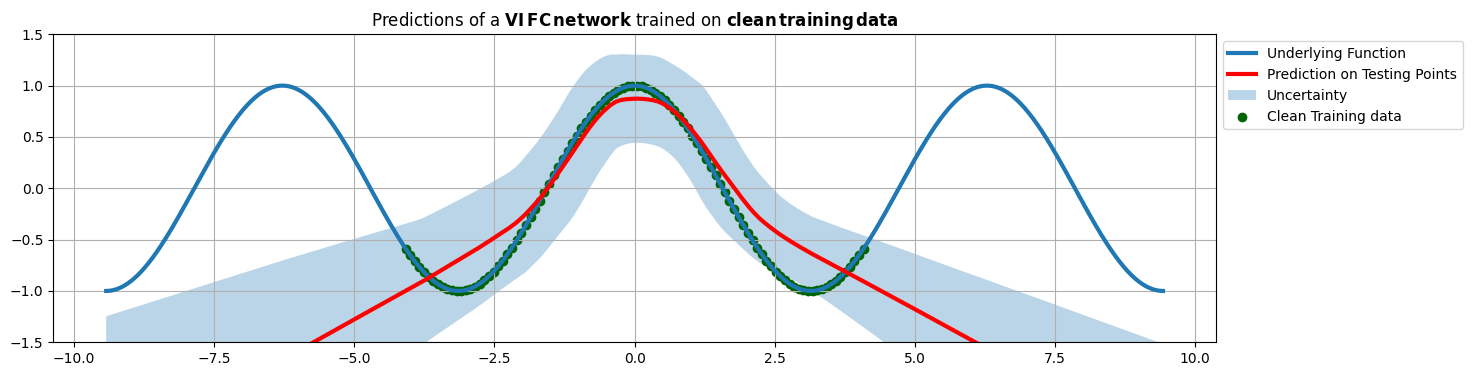

In [92]:
params,\
train_loss,\
test_loss = run_training_loop(num_epochs,
                              opt_state,
                              X_train,
                              Y_train_true,
                              X_test,
                              Y_test_true)
visualize_VI(params,
             X_train,
             Y_train_true,
             r'Predictions of a $\bf{VI\, FC\, network}$'
             r' trained on $\bf{clean\, training\, data}$',
             num_trials = 10)

Epoch 1 | T: 0.006995 | Train loss: 186.056 | Test loss: 305.660
Epoch 50 | T: 0.001649 | Train loss: 151.947 | Test loss: 515.623
Epoch 100 | T: 0.008308 | Train loss: 142.649 | Test loss: 288.436
Epoch 150 | T: 0.001728 | Train loss: 131.225 | Test loss: 599.120
Epoch 200 | T: 0.002218 | Train loss: 121.337 | Test loss: 473.607
Epoch 250 | T: 0.001915 | Train loss: 123.680 | Test loss: 651.718


100%|██████████| 10/10 [00:00<00:00, 147.58it/s]

(10, 200)


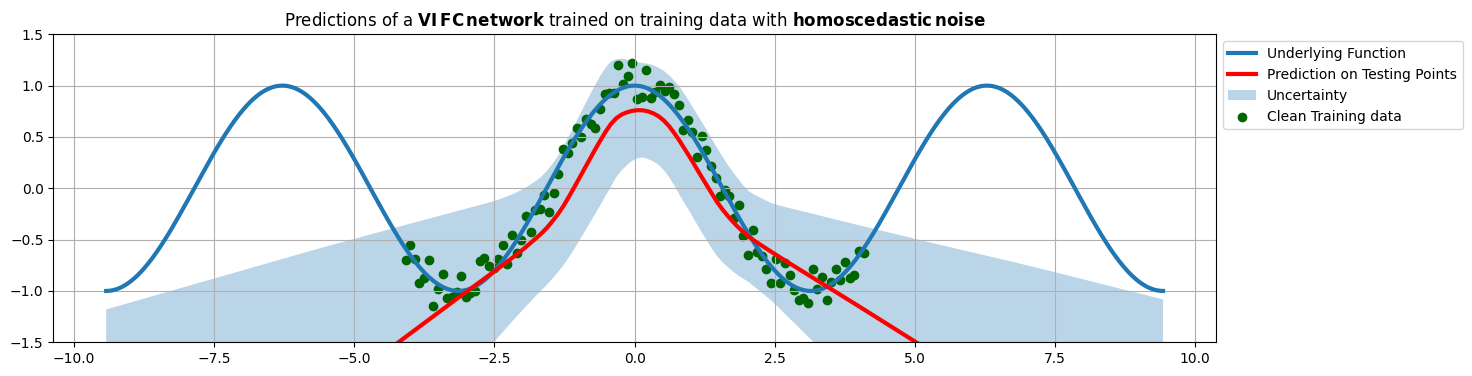

In [93]:
params,\
train_loss,\
test_loss = run_training_loop(num_epochs,
                              opt_state,
                              X_train,
                              Y_train_hom,
                              X_test,
                              Y_test_true)
visualize_VI(params,
             X_train,
             Y_train_hom,
             r'Predictions of a $\bf{VI\, FC\, network}$'
             r' trained on training data with $\bf{homoscedastic\, noise}$',
             num_trials = 10)

Epoch 1 | T: 0.012268 | Train loss: 185.643 | Test loss: 305.451
Epoch 50 | T: 0.001994 | Train loss: 154.941 | Test loss: 874.398
Epoch 100 | T: 0.002017 | Train loss: 143.833 | Test loss: 857.993
Epoch 150 | T: 0.001962 | Train loss: 126.669 | Test loss: 795.195
Epoch 200 | T: 0.001992 | Train loss: 123.605 | Test loss: 620.307
Epoch 250 | T: 0.002363 | Train loss: 118.862 | Test loss: 585.917


100%|██████████| 10/10 [00:00<00:00, 78.07it/s]

(10, 200)


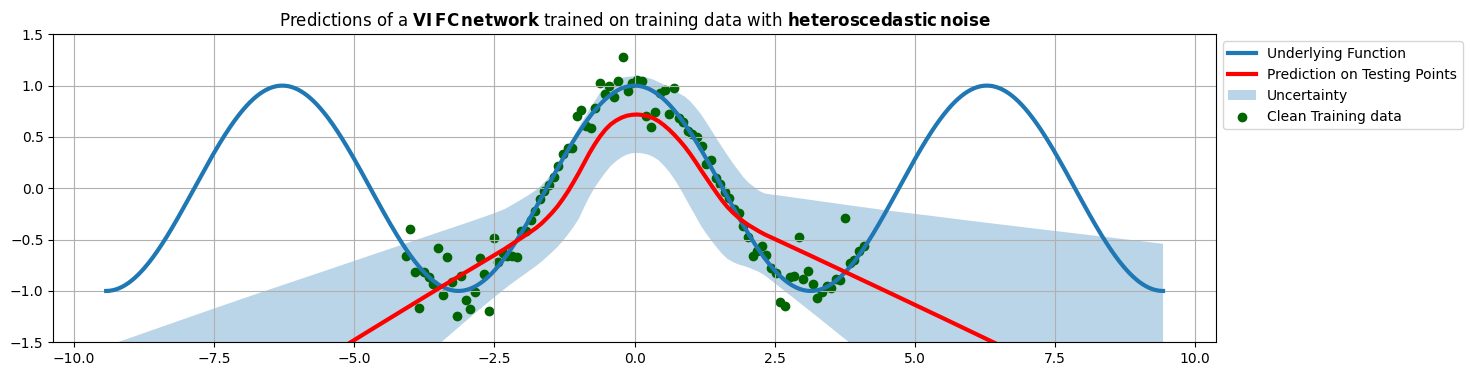

In [94]:
params,\
train_loss,\
test_loss = run_training_loop(num_epochs,
                              opt_state,
                              X_train,
                              Y_train_het,
                              X_test,
                              Y_test_true)
visualize_VI(params,
             X_train,
             Y_train_het,
             r'Predictions of a $\bf{VI\, FC\, network}$'
             r' trained on training data with $\bf{heteroscedastic\, noise}$',
             num_trials = 10)

**Note 1.** A proper implementation would show growing uncertainty as we move away from the training region irrespective of existence and type of noise. This is essentially what we expect of epistemic uncertainty, i.e., showing increased uncertainty as the test data get further away from the observed training data!

**Note 2.** The aleatoric uncertainty is not properly captured as, unlike the first part of this practical, we did not model the output variance (had it fixed to $c^2$). So, there can be too much or too low uncertainty for the observed region of the input (training data).

**Note 3.** You might not get a good fit of the training data depending on the hyperparameters and implementation. That is fine and is a result of the multiple terms in the loss function.


However, remember we used a very simplistic way of modeling Bayesian uncertainty which can be improved using more advanced and recent techniques.

Finally, it is valuable for us to know how long did it take you to complete this practical?

The full practical took us [**3**] hours to be completed.